### Basic implementation of DAISY descriptor

#### DAISY Algorithm
DAISY samples the local gradient information as shown in a figure below. Each circle represents a region where the radius is proportional to the standard deviations of the Gaussian kernels. Dots represents locations where the Convolved Orientation Maps are sampled.

<img src="DAISY-descriptor-structure.png" style="width: 300px;">

Each circle represents one histogram region, which is part of the descriptor vector. Each histogram represents the Gradient Orientations (GOs) within this region. The gradient is split into $H$ discrete orientations, so each single histogram has $H$ entries.

Algortihm uses $Q$ rings around the central point, on which the hstograms are sampled, each ring has $T$ histograms.

Therefore, each descriptor has $D_s=(Q \centerdot T+1)\centerdot H$ entries.

To compute GOs, several oriented derivatives of Gaussian filters are computed as following:

$$G_o^\sigma = G_\sigma * \left(\dfrac{dI}{do}\right)^+ , \left(\dfrac{dI}{do}\right)^+ = max\left(\dfrac{dI}{do}, 0\right),$$
where $ G_\sigma$ is a Gaussian kernel with standard deviation $\sigma$ and $o$ is a derivative orientation.

The results $G_o^\sigma$ are referred as Convolved Orientation Maps (COMs).

Flattening the results to a single vector and normalizing to unit norm gives the DAISY descriptor vector.

#### TODO read and write here more about last step 

In [12]:
import numpy as np

from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v, gaussian

import matplotlib.pyplot as plt
import seaborn as sb


from skimage.draw import (line, circle_perimeter)

%matplotlib notebook 
%rehashx

### DAISY implementation
Next function computes a single COM at given point. As image derivative we use a Sobel filter.
Standard edge-detection filter can work only in $x$ or $y$ axis.
However, method, known as steerable filter, allows us to compute derivative at any virtual axis $z$ at some angle $\theta$:
$$d_z = d_x \cos(\theta) + d_y \sin(\theta)$$

In [2]:
# Computes a Convolved Orientation Map at point (i,j) 
# with specified size, derivative axis angle tetha
# and Gaussian filter std sigma
def sample_com(image, coords, tetha, sigma):
    i, j, size = coords
    data = image[int(i-size/2):int(i+size/2), int(j-size/2):int(j+size/2)]
    # Steering filter - combination of X and Y derivatives 
    # to det a derivative on a specific angle
    d_hor = sobel_h(data)
    d_ver = sobel_v(data)
    derivative = d_hor * np.cos(tetha) + d_ver * np.sin(tetha)
    # Applying gaussian filter to derivative
    com = gaussian(derivative, sigma=sigma)
    return com

Here is the main DAISY function. For illustrative purposes, we compute only one descriptor, at the center of the image. Function returns $Ds$ entries, as described abowe. Flattening the resulting array will give us the descriptor vector.

In [3]:
# Implemetation of DAISY with a single descriptor for
# a center point of the image
def daisy(image, R, Q, T, H, sigma):
    
    tetha_step = 2 * np.pi / T
    radius_step = float(R) / Q
    Ds = (Q*T+1)*H
    # Copy of image for visualization
    visualize = np.copy(image)
    
    coms = []
    # Center point
    x, y = image.shape
    center = [int(x/2), int(y/2)]
    
    # TODO set initial radius as a portion of a whole?
    single_com_r_initial = 8
    
    compute_com_at_position((center[0], center[1], single_com_r_initial), sigma, visualize)
    
    # Walk over DAISY circles pattern
    for i in range(0, Q):
        r = i * radius_step
        # TODO change radius by Gaussian distribution?
        single_com_r = single_com_r_initial
        if(i > 0):
            single_com_r = int(i * single_com_r)
        for j in range(0, T):
            tetha = j * tetha_step
            x = int(center[0] + r * np.cos(tetha))
            y = int(center[1] + r * np.sin(tetha))
            coms.append(compute_com_at_position((x, y, single_com_r), sigma, visualize))
    
    return coms, visualize

# Compute and visualize COMs for a given coordinate
def compute_com_at_position(coords, sigma, visualize):
    i, j, size = coords
    tetha_step = 2 * np.pi / H

    # Draw circle
    rr, cc = circle_perimeter(i, j, size)
    visualize[rr, cc] = 255
    result = []

    # Compute H COMs
    for k in range(0, H):
        tetha = tetha_step * k

        # Draw line
        line_len = int(size * 0.7)
        i0 = int(i + line_len * np.sin(tetha))
        j0 = int(j + line_len * np.cos(tetha))
        rr1, cc1 = line(i, j, i0, j0)
        visualize[rr1, cc1] = 255
        # Compute COM
        result.append(sample_com(image, coords, tetha, sigma))
        
    return result

#### Utility functions

In [4]:
def imgshow(image, title='', cmap=plt.cm.gray):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    plt.show()
    
def show_coms(coms, idx):
    single_set = coms[idx]
    grid_i = 2
    grid_j = int(np.floor(len(single_set) / 2))
    fig, ax = plt.subplots(grid_i, grid_j)
    for i in range(0, grid_i):
        for j in range(0, grid_j):
            idx = i*grid_i+j
            if(idx >= len(single_set)):
                break
            ax[i, j].imshow(single_set[idx], cmap = plt.cm.plasma)

#### Test data preparation
We use a 128 * 128 sample of a contrast grayscale image from skimage.data

<IPython.core.display.Javascript object>


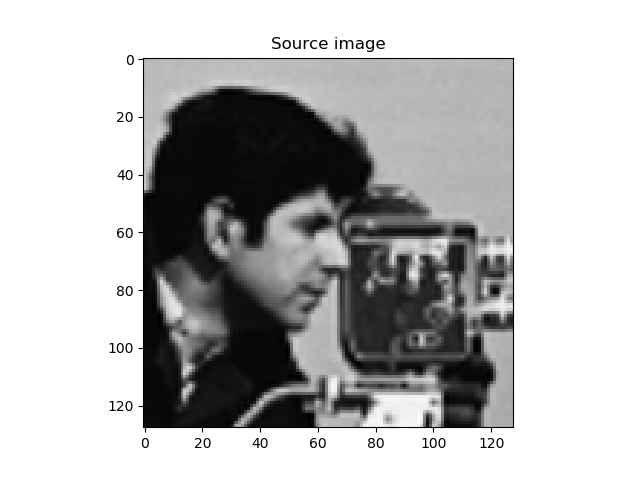

Image size:(128, 128)


In [13]:
img_src = data.camera()

center = [128, 256]
size = [128, 128]

image = img_src[int(center[0]-size[0] / 2):int(center[0]+size[0] / 2), 
           int(center[1]-size[1] / 2):int(center[1]+size[1] / 2)]
imgshow(image, 'Source image')
print(f'Image size:{image.shape}')

### Testing section 
Here is the list of modifiable parameters:
* Maximum radius $R$
* Number of rings $Q$
* Number of points per ring $T$
* Number of histograms per point $H$
* Gaussian filter standard deviation $\sigma$

In [6]:
R = 64
Q = 3
T = 8
H = 6
SIGMA = 5

In [7]:
coms, visualize = daisy(image, R, Q, T, H, SIGMA)

<IPython.core.display.Javascript object>


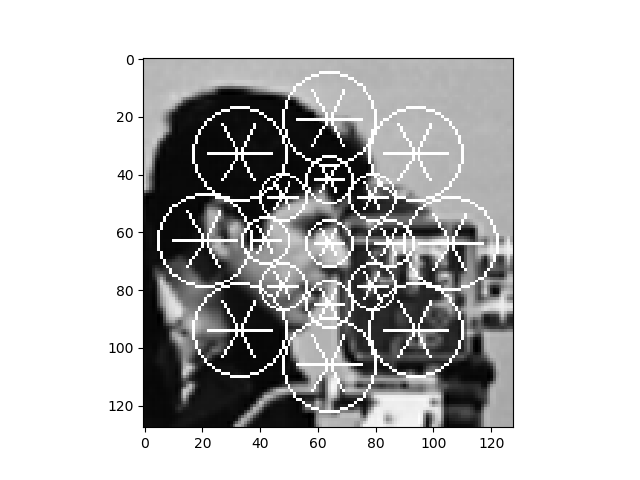

In [14]:
imgshow(visualize)

Here we can explore the resulting COM's. For example, let's check COM's for the first (center) point:

<IPython.core.display.Javascript object>


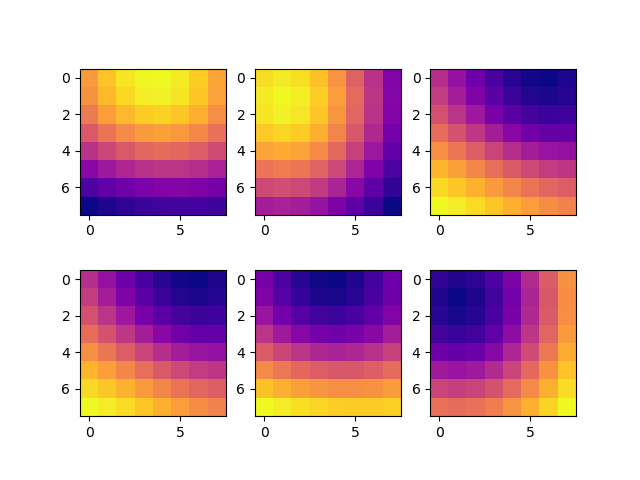

In [15]:
show_coms(coms, 0)

Now let's have a look at the last one:

<IPython.core.display.Javascript object>


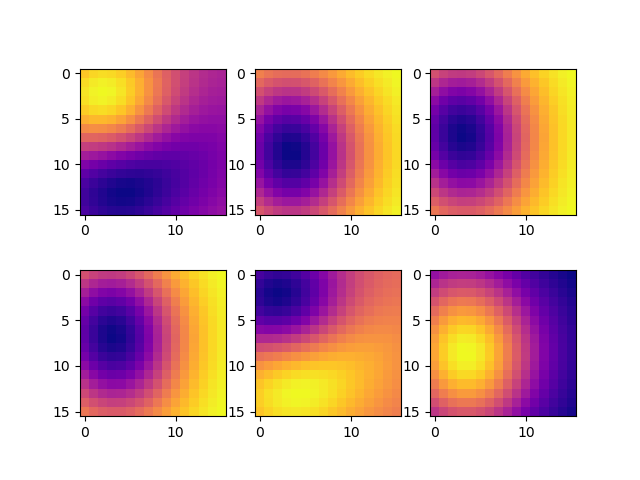

In [16]:
show_coms(coms, -1)

## Next steps
There will be descriptor normalization and testing the scale and rotation invariancy. 